### Model

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.fc1 = nn.Linear(2048, 512)  # Adjusted for potential flattening size
        self.bn6 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, latent_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.bn6(self.fc1(x)))
        x = self.fc2(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_channels):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 1024)
        self.bn0 = nn.BatchNorm1d(1024)
        self.conv2d_t1 = nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.conv2d_t2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.conv2d_t3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv2d_t4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv2d_t5 = nn.ConvTranspose2d(64, output_channels, kernel_size=(2,1), stride=(3,2), padding=(7,9), output_padding=(0,1))

    def forward(self, z):
        z = F.relu(self.bn0(self.fc(z)))
        z = z.view(-1, 1024, 1, 1)
        z = F.relu(self.bn1(self.conv2d_t1(z)))
        z = F.relu(self.bn2(self.conv2d_t2(z)))
        z = F.relu(self.bn3(self.conv2d_t3(z)))
        z = F.relu(self.bn4(self.conv2d_t4(z)))
        reconstruction = torch.sigmoid(self.conv2d_t5(z))
        return reconstruction

# class VAE(nn.Module):
#     def __init__(self, input_channels, latent_dim, output_channels):
#         super(VAE, self).__init__()
#         self.encoder = Encoder(input_channels, latent_dim)
#         self.decoder = Decoder(latent_dim, output_channels)

#     def reparameterize(self, mean, log_var):
#         std = torch.exp(0.5 * log_var)
#         eps = torch.randn_like(std)
#         return mean + eps * std

#     def forward(self, x):
#         mean, log_var = self.encoder(x)
#         z = self.reparameterize(mean, log_var)
#         return self.decoder(z), mean, log_var
    
class VAE(nn.Module):
    def __init__(self, input_channels, latent_dim, output_channels):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_channels, latent_dim)
        self.decoder = Decoder(latent_dim, output_channels)

    def forward(self, x):
        z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction, z

In [32]:

class Classifier(nn.Module):
    def __init__(self, latent_dim, num_classes=11):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        class_logits = self.classifier(x)
        return class_logits

In [3]:
from scipy.stats import mode
from scipy.signal import resample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import stft

def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * float(target_fs) / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal

def resample_dataset(data, original_fs, target_fs):
    # Initialize lists to hold resampled data
    resampled_signals = []
    resampled_labels = []

    # Group by activity to handle each activity block separately
    grouped = data.groupby('activity')

    for activity, group in grouped:
        # Resample each accelerometer axis
        for column in ['acc_x', 'acc_y', 'acc_z']:
            resampled_signal = resample_signal(group[column].values, original_fs, target_fs)
            if column == 'acc_x':
                # Only extend labels once per group of resampling
                resampled_labels.extend([activity] * len(resampled_signal))
            resampled_signals.append(resampled_signal)

    # Reconstruct the DataFrame
    # Assuming resampling keeps all axes the same length
    resampled_df = pd.DataFrame({
        'acc_x': np.concatenate([s for s in resampled_signals[0::3]]),
        'acc_y': np.concatenate([s for s in resampled_signals[1::3]]),
        'acc_z': np.concatenate([s for s in resampled_signals[2::3]]),
        'activity': resampled_labels
    })

    return resampled_df

def create_overlapping_windows_with_labels(signals, labels, window_size, overlap_size):
    step_size = window_size - overlap_size
    windowed_signals = []
    windowed_labels = []
    total_windows = 0

    for start in range(0, len(signals[0]) - window_size + 1, step_size):  # Assumes all signals are the same length
        end = start + window_size
        window = [signal[start:end] for signal in signals]
        label_window = labels[start:end]
        if len(window[0]) == window_size and len(label_window) == window_size:
            windowed_signals.append(window)
            # Using mode of labels in the window as the window label
            windowed_label = mode(label_window)[0]
            windowed_labels.append(windowed_label)
            total_windows += 1
        else:
            print(f"Skipped window from {start} to {end} due to incorrect size.")

    return np.array(windowed_signals), np.array(windowed_labels)

def create_overlapping_windows(signals, window_size, overlap_size):
    step_size = window_size - overlap_size
    windowed_signals = []
    windowed_labels = []
    total_windows = 0

    for start in range(0, len(signals[0]) - window_size + 1, step_size):  # Assumes all signals are the same length
        end = start + window_size
        window = [signal[start:end] for signal in signals]
        if len(window[0]) == window_size:
            windowed_signals.append(window)
            total_windows += 1
        else:
            print(f"Skipped window from {start} to {end} due to incorrect size.")

    return np.array(windowed_signals), np.array(windowed_labels)

def generate_multi_channel_spectrogram(windows, fs, window_type, nperseg, noverlap, nfft):
    spectrograms = []
    for window in windows:
        # Assuming window is a 2D array with shape (window_size, num_channels)
        window_spectrograms = []
        for signal in window:  # Transpose to iterate over channels
            _, _, Zxx = stft(signal, fs=fs, window=window_type, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
            spectrogram = np.log(np.abs(Zxx) + 1e-8)  # Convert to dB scale
            # # Normalize the spectrogram
            # mean = np.mean(spectrogram)
            # std = np.std(spectrogram)
            # spectrogram = (spectrogram - mean) / std
            window_spectrograms.append(spectrogram)
        # Stack to form a multi-channel spectrogram for this window
        spectrograms.append(np.stack(window_spectrograms, axis=0))
    return np.array(spectrograms)

def plot_simple_spectrogram(spectrogram, channel=0, title="Spectrogram"):
    # spectrogram should be a 3D array: [frequency, time, channel]
    plt.figure(figsize=(10, 4))
    # Display the spectrogram of a specific channel
    plt.imshow(spectrogram[:, :, channel].T, aspect='auto', origin='lower')
    plt.colorbar(label='Intensity (dB)')
    plt.title(title)
    plt.ylabel('Sample Index')
    plt.xlabel('Time Index')
    plt.show()
    
def generate_activity_grouped_spectrograms(data, fs, window_size, overlap_size, window_type, nperseg, noverlap, nfft):
    activity_spectrograms = {}
    grouped_data = data.groupby('activity')
    for name, group in grouped_data:
        # print(len(group))
        windowed_signals, _ = create_overlapping_windows([group['acc_x'].values, group['acc_y'].values, group['acc_z'].values], window_size, overlap_size)
        # print(len(windowed_signals))
        spectrograms = generate_multi_channel_spectrogram(windowed_signals, fs, window_type, nperseg, noverlap, nfft)
        activity_spectrograms[name] = spectrograms
    return activity_spectrograms

### UPFALL

In [4]:

UPFall_data_path = '../datasets/UPFallCompleteDataSet.csv'
UPFall_data = pd.read_csv(UPFall_data_path, skiprows=1, usecols=[0, 15, 16, 17, 44])  # Adjust column indices as needed

g = 9.81

# Rename columns for clarity
UPFall_data.columns = ['timestamp', 'acc_x', 'acc_y', 'acc_z', 'activity']

UPFall_data['activity'] -= 1
UPFall_data['timestamp'] = pd.to_datetime(UPFall_data['timestamp'])

# Drop rows with any NaN values
UPFall_data = UPFall_data.dropna()

UPFall_data

,timestamp,acc_x,acc_y,acc_z,activity
0,2018-07-04 12:04:17.738369,0.146,0.895,0.367,0
1,2018-07-04 12:04:17.790509,0.146,0.895,0.367,0
2,2018-07-04 12:04:17.836632,0.178,0.896,0.373,0
3,2018-07-04 12:04:17.885262,0.160,0.895,0.372,0
4,2018-07-04 12:04:17.945423,0.160,0.895,0.372,0
...,...,...,...,...,...
294673,2018-07-12 12:18:28.783680,-0.377,-0.095,0.989,10
294674,2018-07-12 12:18:28.832811,-0.376,-0.090,0.998,10
294675,2018-07-12 12:18:28.892470,-0.376,-0.090,0.998,10
294676,2018-07-12 12:18:29.025324,-0.381,-0.101,0.992,10


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

UPFall_data = resample_dataset(UPFall_data, 18, 67)

means = UPFall_data[['acc_x', 'acc_y', 'acc_z']].mean()
std = UPFall_data[['acc_x', 'acc_y', 'acc_z']].std()
UPFall_data[['acc_x', 'acc_y', 'acc_z']] = (UPFall_data[['acc_x', 'acc_y', 'acc_z']] - means) / std

# Example parameters
window_size = 200 # aroung 3 sec of data
overlap_size = 100
fs = 67  
UPFall_signals = [UPFall_data['acc_x'].values, UPFall_data['acc_y'].values, UPFall_data['acc_z'].values]
UPFall_activities = UPFall_data['activity'].values

# Create overlapping windows for each signal and stack them to form multi-dimensional windows
UPFall_windowed_signals, UPFall_windowed_labels = create_overlapping_windows_with_labels(UPFall_signals, UPFall_activities, window_size, overlap_size)

# Generate spectrograms for each window
window_type='hann'
nperseg=32
noverlap=16
nfft=64
UPFall_spectrograms = generate_multi_channel_spectrogram(UPFall_windowed_signals, fs, window_type, nperseg, noverlap, nfft)

UPFall_spectrograms_by_activity = generate_activity_grouped_spectrograms(UPFall_data, fs, window_size, overlap_size, window_type, nperseg, noverlap, nfft)

# Flatten the dictionary into lists
X = []
UPFall_X = []
UPFall_y = []
for activity, spectrograms in UPFall_spectrograms_by_activity.items():
    for spectrogram in spectrograms:
        X.append(spectrogram)
        UPFall_X.append(spectrogram)
        UPFall_y.append(activity)  # assuming the key 'activity' is the label

print(len(X))

40812


### MHEALTH

In [6]:
import os

MHEALTH_data_path = '../datasets/MHEALTHDATASET_CSV/'

# List all CSV files in the directory
MHEALTH_files = [f for f in os.listdir(MHEALTH_data_path) if f.endswith('.csv')]

# Create a list to hold dataframes
MHEALTH_dataframes = []

# Loop through the files and read each one into a dataframe
for file in MHEALTH_files:
    file_path = os.path.join(MHEALTH_data_path, file)
    df = pd.read_csv(file_path, skiprows=1, usecols=[0, 1, 2, 23])  # Adjust column indices as needed
    df.columns = ['acc_x', 'acc_y', 'acc_z', 'activity']
    MHEALTH_dataframes.append(df)

# Concatenate all the dataframes into one
MHEALTH_data = pd.concat(MHEALTH_dataframes, ignore_index=True)

# convert unit to g
MHEALTH_data['acc_x'] = MHEALTH_data['acc_x']/g
MHEALTH_data['acc_y'] = MHEALTH_data['acc_y']/g
MHEALTH_data['acc_z'] = MHEALTH_data['acc_z']/g

MHEALTH_data

,acc_x,acc_y,acc_z,activity
0,-1.003965,0.053419,0.038071,0.0
1,-0.984730,0.018537,0.044589,0.0
2,-0.983761,0.021837,0.024498,0.0
3,-0.989093,0.030978,0.031759,0.0
4,-0.983802,0.023712,0.042909,0.0
...,...,...,...,...
1215730,-1.248114,-0.302813,-0.003646,0.0
1215731,-1.113354,-0.348522,-0.034585,0.0
1215732,-0.966789,-0.312365,-0.105372,0.0
1215733,-0.895912,-0.252365,-0.062415,0.0


In [7]:
MHEALTH_data = resample_dataset(MHEALTH_data, 50, 67)

# Standardize
means = MHEALTH_data[['acc_x', 'acc_y', 'acc_z']].mean()
std = MHEALTH_data[['acc_x', 'acc_y', 'acc_z']].std()
MHEALTH_data[['acc_x', 'acc_y', 'acc_z']] = (MHEALTH_data[['acc_x', 'acc_y', 'acc_z']] - means) / std

MHEALTH_signals = [MHEALTH_data['acc_x'].values, MHEALTH_data['acc_y'].values, MHEALTH_data['acc_z'].values]
MHEALTH_activities = MHEALTH_data['activity'].values

# Create overlapping windows for each signal and stack them to form multi-dimensional windows
MHEALTH_windowed_signals, MHEALTH_windowed_labels = create_overlapping_windows_with_labels(MHEALTH_signals, MHEALTH_activities, window_size, overlap_size)

MHEALTH_spectrograms = generate_multi_channel_spectrogram(MHEALTH_windowed_signals, fs, window_type, nperseg, noverlap, nfft)

MHEALTH_spectrograms_by_activity = generate_activity_grouped_spectrograms(MHEALTH_data, fs, window_size, overlap_size, window_type, nperseg, noverlap, nfft)

# Flatten the dictionary into lists
MHEALTH_y = []
for activity, spectrograms in MHEALTH_spectrograms_by_activity.items():
    for spectrogram in spectrograms:
        X.append(spectrogram)
        MHEALTH_y.append(activity)  # assuming the key 'activity' is the label

In [8]:
print(len(X))

27223


### DaphNet

In [9]:
import os

Daphnet_data_path = '../datasets/Daphnet_CSV/'

# List all CSV files in the directory
Daphnet_files = [f for f in os.listdir(Daphnet_data_path) if f.endswith('.csv')]

# Create a list to hold dataframes
Daphnet_dataframes = []

# Loop through the files and read each one into a dataframe
for file in Daphnet_files:
    file_path = os.path.join(Daphnet_data_path, file)
    df = pd.read_csv(file_path, skiprows=1, usecols=[7, 8, 9, 10])  # Adjust column indices as needed
    df.columns = ['acc_x', 'acc_y', 'acc_z', 'activity']
    Daphnet_dataframes.append(df)

# Concatenate all the dataframes into one
Daphnet_data = pd.concat(Daphnet_dataframes, ignore_index=True)
# remove rows with all zeroes
Daphnet_data = Daphnet_data.loc[~((Daphnet_data['acc_x'] == 0) & (Daphnet_data['acc_y'] == 0) & (Daphnet_data['acc_z'] == 0))]

# convert unit to g
Daphnet_data['acc_x'] = Daphnet_data['acc_x']/1000
Daphnet_data['acc_y'] = Daphnet_data['acc_y']/1000
Daphnet_data['acc_z'] = Daphnet_data['acc_z']/1000

Daphnet_data

,acc_x,acc_y,acc_z,activity
443,0.135,0.057,-0.961,0.0
444,0.135,0.057,-0.961,0.0
445,0.126,0.047,-0.961,0.0
446,0.126,0.047,-0.961,0.0
447,0.106,0.047,-0.970,0.0
...,...,...,...,...
1885863,-0.553,0.619,-2.145,1.0
1885864,-0.553,0.619,-2.145,1.0
1885865,-0.553,0.619,-2.145,1.0
1885866,-0.553,0.619,-2.145,1.0


In [10]:
# Standardize
means = Daphnet_data[['acc_x', 'acc_y', 'acc_z']].mean()
std = Daphnet_data[['acc_x', 'acc_y', 'acc_z']].std()
Daphnet_data[['acc_x', 'acc_y', 'acc_z']] = (Daphnet_data[['acc_x', 'acc_y', 'acc_z']] - means) / std

Daphnet_signals = [Daphnet_data['acc_x'].values, Daphnet_data['acc_y'].values, Daphnet_data['acc_z'].values]
Daphnet_activities = Daphnet_data['activity'].values

# Create overlapping windows for each signal and stack them to form multi-dimensional windows
Daphnet_windowed_signals, Daphnet_windowed_labels = create_overlapping_windows_with_labels(Daphnet_signals, Daphnet_activities, window_size, overlap_size)

Daphnet_spectrograms = generate_multi_channel_spectrogram(Daphnet_windowed_signals, fs, window_type, nperseg, noverlap, nfft)

Daphnet_spectrograms_by_activity = generate_activity_grouped_spectrograms(Daphnet_data, fs, window_size, overlap_size, window_type, nperseg, noverlap, nfft)

# Flatten the dictionary into lists
Daphnet_y = []
for activity, spectrograms in Daphnet_spectrograms_by_activity.items():
    for spectrogram in spectrograms:
        X.append(spectrogram)
        Daphnet_y.append(activity)  # assuming the key 'activity' is the label
        
print(len(X))

46038


In [11]:
X_by_activity = np.array(X)

# Split the data
X_train, X_val = train_test_split(X_by_activity, test_size=0.3, random_state=42)

In [12]:
class Data_Supervised(torch.utils.data.Dataset):
  def __init__(self, X, y, device='cuda'):
    self.x_data = torch.tensor(X, dtype=torch.float32).to(device)
    self.y_data = torch.tensor(y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    seq_in = self.x_data[idx]
    target = self.y_data[idx]
    sample = { 'spectrograms' : seq_in, 'label' : target }
    return sample

class Data_Unsupervised(torch.utils.data.Dataset):
  def __init__(self, X, device='cuda'):
    self.x_data = torch.tensor(X, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    seq_in = self.x_data[idx]
    sample = { 'spectrograms' : seq_in }
    return sample

In [13]:
# from torch.optim.lr_scheduler import StepLR
# from sklearn.metrics import f1_score

# # Loss function
# def supervised_vae_loss(recon_x, x, logits, labels):
#     # print(f"Recon_x size: {recon_x.size()}, x size: {x.size()}")
#     MAE = F.l1_loss(recon_x, x, reduction='sum')
#     # KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
#     labels = labels.long()
#     CE = F.cross_entropy(logits, labels)
#     return MAE, CE
# def unsupervised_vae_loss(recon_x, x):
#     # print(f"Recon_x size: {recon_x.size()}, x size: {x.size()}")
#     MAE = F.l1_loss(recon_x, x, reduction='sum')
#     # KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
#     return MAE

# # Train Function
# def train_unsupervised_vae(model, train_loader, val_loader, epochs, learning_rate=1e-3, device='cuda'):
#     model.to(device)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
#     train_losses, val_losses = [], []

#     last_epoch = 1
    
#     for epoch in range(epochs):
#         model.train()
#         total_train_loss = 0
        
#         if epoch - last_epoch == 10:
#             learning_rate /= 10
#             # last_epoch = epoch

#         for batch in train_loader:
#             data = batch['spectrograms'].to(device)
#             optimizer.zero_grad()
#             recon_batch, class_logits = model(data)
#             MAE = unsupervised_vae_loss(recon_batch, data)
#             loss = MAE
#             loss.backward()
#             optimizer.step()
#             total_train_loss += loss.item()
            
#         # Learning rate scheduling
#         # scheduler.step()

#         # Validation phase
#         model.eval()
#         total_val_loss = 0
#         with torch.no_grad():
#             for batch in val_loader:
#                 data = batch['spectrograms'].to(device)
#                 recon_batch, class_logits = model(data)
#                 MAE = unsupervised_vae_loss(recon_batch, data)
#                 loss = MAE
#                 total_val_loss += loss.item()

#         # Logging the average losses
#         avg_train_loss = total_train_loss / len(train_loader)

#         avg_val_loss = total_val_loss / len(val_loader)
        
#         train_losses.append(avg_train_loss)
#         val_losses.append(avg_val_loss)

#         print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}')
#         print(f'Validation Loss: {avg_val_loss:.4f}')
    
#     return train_losses, val_losses
        
# def train_supervised_vae(model, train_loader, val_loader, epochs, learning_rate, training, device='cuda'):
#     model.to(device)
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     if training == 2:
#         optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.1)
#     scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

#     train_losses, val_losses, train_f1_scores, val_f1_scores = [], [], [], []
#     last_epoch = 1
    
#     for epoch in range(epochs):
        
#         # if epoch - last_epoch == 10:
#         #     learning_rate /= 10
#         #     last_epoch = epoch
            
#         model.train()
#         total_train_loss = 0
#         total_train_MAE = 0
#         total_train_CE = 0
#         all_train_predictions = []
#         all_train_labels = []

#         for batch in train_loader:
#             data = batch['spectrograms'].to(device)
#             labels = batch['label'].to(device)
#             optimizer.zero_grad()
#             recon_batch, class_logits = model(data)
#             MAE, CE = supervised_vae_loss(recon_batch, data, class_logits, labels)
#             loss = CE + MAE
#             if training == 2:
#                 loss = CE
#             loss.backward()
#             optimizer.step()
#             total_train_loss += loss.item()
#             total_train_MAE += MAE.item()
#             total_train_CE += CE.item()
            
#             # Convert logits to predictions
#             predictions = torch.argmax(class_logits, dim=1)
#             all_train_predictions.extend(predictions.cpu().numpy())
#             all_train_labels.extend(labels.cpu().numpy())
            
            
#         # Calculate F1 Score
#         train_f1 = f1_score(all_train_labels, all_train_predictions, average='macro')  # Change 'macro' to other methods if needed
#         # Learning rate scheduling
#         if training == 1 or training == 2:
#             scheduler.step()
#         elif epoch == 10:
#             learning_rate /= 10

#         # Validation phase
#         model.eval()
#         total_val_loss = 0
#         total_val_MAE = 0
#         total_val_CE = 0
#         all_val_predictions = []
#         all_val_labels = []
#         with torch.no_grad():
#             for batch in val_loader:
#                 data = batch['spectrograms'].to(device)
#                 labels = batch['label'].to(device)
#                 recon_batch, class_logits = model(data)
#                 MAE, CE = supervised_vae_loss(recon_batch, data, class_logits, labels)
#                 loss = CE + MAE
#                 if training == 2:
#                     loss = CE
#                 total_val_loss += loss.item()
#                 total_val_MAE += MAE.item()
#                 total_val_CE += CE.item()
                
#                 val_predictions = torch.argmax(class_logits, dim=1)
#                 all_val_predictions.extend(val_predictions.cpu().numpy())
#                 all_val_labels.extend(labels.cpu().numpy())
                
#                 # if epoch == 20:
#                 #     wrong = 0
#                 #     right = 0
#                 #     for i in range(len(all_train_labels)):
#                 #         print(f'predict: {all_train_predictions[i]}, label: {all_train_labels[i]}')
#                 #         if all_train_predictions[i] != all_train_labels[i]:
#                 #             wrong += 1
#                 #         else:
#                 #             right += 1
                    
#                 #     print(f'right: {right}, wrong: {wrong}')

  
#         val_f1 = f1_score(all_val_labels, all_val_predictions, average='macro')  # Calculate validation F1 Score

#         # Logging the average losses
#         avg_train_loss = total_train_loss / len(train_loader)
#         avg_train_MAE = total_train_MAE / len(train_loader)
#         avg_train_CE = total_train_CE / len(train_loader)

#         avg_val_loss = total_val_loss / len(val_loader)
#         avg_val_MAE = total_val_MAE / len(val_loader)
#         avg_val_CE = total_val_CE / len(val_loader)
        
#         if epoch != 0:
#             train_losses.append(avg_train_loss)
#             val_losses.append(avg_val_loss)
#             train_f1_scores.append(train_f1)
#             val_f1_scores.append(val_f1)

#         print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train CE: {avg_train_CE:.4f}, Train F1: {train_f1:.4f}')
#         print(f'Validation Loss: {avg_val_loss:.4f}, Validation CE: {avg_val_CE:.4f}, Validatiob F1: {val_f1:.4f}')
        
#     return train_losses, val_losses, train_f1_scores, val_f1_scores

In [40]:
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import f1_score

# Loss function
def classifier_loss(logits, labels):
    labels = labels.long()
    CE = F.cross_entropy(logits, labels)
    return CE
def vae_loss(recon_x, x):
    # print(f"Recon_x size: {recon_x.size()}, x size: {x.size()}")
    MAE = F.l1_loss(recon_x, x, reduction='sum')
    # KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return MAE

# Train Function
def train_vae(model, train_loader, val_loader, epochs, learning_rate=1e-3, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    train_losses, val_losses = [], []

    last_epoch = 1
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        
        # if epoch - last_epoch == 10:
        #     learning_rate /= 10
        #     last_epoch = epoch

        for batch in train_loader:
            data = batch['spectrograms'].to(device)
            optimizer.zero_grad()
            recon_batch, class_logits = model(data)
            MAE = vae_loss(recon_batch, data)
            loss = MAE
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            
        # Learning rate scheduling
        # scheduler.step()

        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                data = batch['spectrograms'].to(device)
                recon_batch, class_logits = model(data)
                MAE = vae_loss(recon_batch, data)
                loss = MAE
                total_val_loss += loss.item()

        # Logging the average losses
        avg_train_loss = total_train_loss / len(train_loader)

        avg_val_loss = total_val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
    
    return train_losses, val_losses
        
def train_classifier(encoder, classifier, train_loader, val_loader, epochs, learning_rate, device='cuda'):
    encoder.eval()
    classifier.to(device)
    optimizer = optim.SGD(classifier.parameters(), lr=learning_rate, momentum=0.8)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    train_losses, val_losses, train_f1_scores, val_f1_scores = [], [], [], []
    last_epoch = 1
    
    for epoch in range(epochs):
        
        if epoch - last_epoch == 30:
            learning_rate /= 10
            last_epoch = epoch
            
        classifier.train()
        total_train_loss = 0
        total_train_CE = 0
        all_train_predictions = []
        all_train_labels = []

        for batch in train_loader:
            data = batch['spectrograms'].to(device)
            labels = batch['label'].to(device)
            with torch.no_grad():
                features = encoder(data)  # Get the latent features
            optimizer.zero_grad()
            class_logits = classifier(features)
            CE = classifier_loss(class_logits, labels)
            loss = CE
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            total_train_CE += CE.item()
            
            # Convert logits to predictions
            predictions = torch.argmax(class_logits, dim=1)
            all_train_predictions.extend(predictions.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
            
            
        # Calculate F1 Score
        train_f1 = f1_score(all_train_labels, all_train_predictions, average='macro')  # Change 'macro' to other methods if needed
        # Learning rate scheduling
        # scheduler.step()

        # Validation phase
        classifier.eval()
        total_val_loss = 0
        total_val_CE = 0
        all_val_predictions = []
        all_val_labels = []
        with torch.no_grad():
            for batch in val_loader:
                data = batch['spectrograms'].to(device)
                labels = batch['label'].to(device)
                with torch.no_grad():
                    features = encoder(data)  # Get the latent features
                class_logits = classifier(features)
                CE = classifier_loss(class_logits, labels)
                loss = CE
                total_val_loss += loss.item()
                total_val_CE += CE.item()
                
                val_predictions = torch.argmax(class_logits, dim=1)
                all_val_predictions.extend(val_predictions.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
                
                # if epoch == 20:
                #     wrong = 0
                #     right = 0
                #     for i in range(len(all_train_labels)):
                #         print(f'predict: {all_train_predictions[i]}, label: {all_train_labels[i]}')
                #         if all_train_predictions[i] != all_train_labels[i]:
                #             wrong += 1
                #         else:
                #             right += 1
                    
                #     print(f'right: {right}, wrong: {wrong}')

  
        val_f1 = f1_score(all_val_labels, all_val_predictions, average='macro')  # Calculate validation F1 Score

        # Logging the average losses
        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_CE = total_train_CE / len(train_loader)

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_CE = total_val_CE / len(val_loader)
        
        if epoch != 0:
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            train_f1_scores.append(train_f1)
            val_f1_scores.append(val_f1)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train CE: {avg_train_CE:.4f}, Train F1: {train_f1:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}, Validation CE: {avg_val_CE:.4f}, Validatiob F1: {val_f1:.4f}')
        
    return train_losses, val_losses, train_f1_scores, val_f1_scores

Epoch 1: Train Loss: 1897611.1002
Validation Loss: 1896939.1481
Epoch 2: Train Loss: 1887393.4038
Validation Loss: 1889637.9352
Epoch 3: Train Loss: 1880186.2103
Validation Loss: 1882511.9514
Epoch 4: Train Loss: 1873156.6637
Validation Loss: 1875587.7361
Epoch 5: Train Loss: 1866361.8204
Validation Loss: 1868931.2222
Epoch 6: Train Loss: 1859862.3482
Validation Loss: 1862596.0208
Epoch 7: Train Loss: 1853704.2470
Validation Loss: 1856620.0255
Epoch 8: Train Loss: 1847916.6994
Validation Loss: 1851022.7801
Epoch 9: Train Loss: 1842419.9891
Validation Loss: 1845685.3102
Epoch 10: Train Loss: 1837368.1300
Validation Loss: 1840865.7176
Epoch 11: Train Loss: 1832730.1944
Validation Loss: 1836410.1412
Epoch 12: Train Loss: 1828456.8294
Validation Loss: 1832346.6620
Epoch 13: Train Loss: 1824487.3948
Validation Loss: 1828517.4722
Epoch 14: Train Loss: 1820876.3155
Validation Loss: 1825054.6481
Epoch 15: Train Loss: 1817569.9077
Validation Loss: 1821894.4699
Epoch 16: Train Loss: 1814550.3849

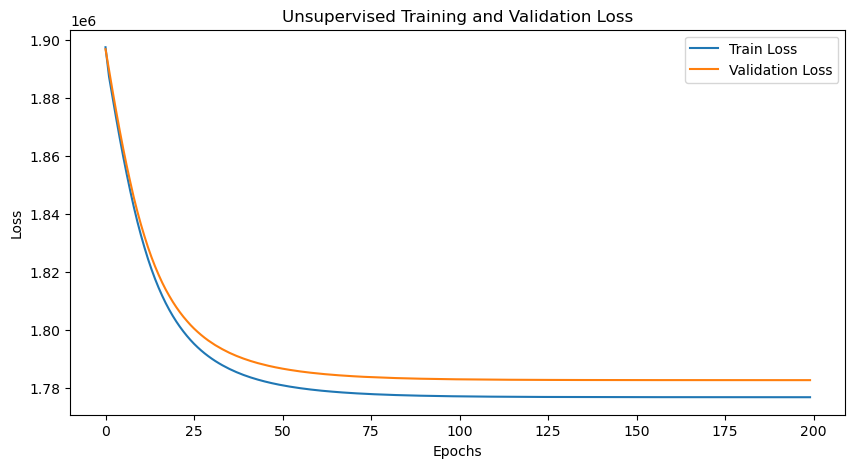

In [16]:
# Convert to PyTorch tensors and create DataLoaders
train_data = Data_Unsupervised(X_train)
val_data = Data_Unsupervised(X_val)
train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
val_loader = DataLoader(val_data, batch_size=256, shuffle=True)

latent_dim = 128
vae_model = VAE(input_channels=3, latent_dim=latent_dim, output_channels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# supervised_vae_model.to(device)
train_losses, val_losses = train_vae(vae_model, train_loader, val_loader, epochs=200, learning_rate=0.001)
torch.save(vae_model.state_dict(), 'vae.pth')

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Unsupervised Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1: Train Loss: 1.7991, Train CE: 1.7991, Train F1: 0.2175
Validation Loss: 1.3301, Validation CE: 1.3301, Validatiob F1: 0.3027
Epoch 2: Train Loss: 1.3665, Train CE: 1.3665, Train F1: 0.3212
Validation Loss: 1.1176, Validation CE: 1.1176, Validatiob F1: 0.3877
Epoch 3: Train Loss: 1.2259, Train CE: 1.2259, Train F1: 0.3611
Validation Loss: 1.0236, Validation CE: 1.0236, Validatiob F1: 0.4013
Epoch 4: Train Loss: 1.1418, Train CE: 1.1418, Train F1: 0.3731
Validation Loss: 0.9721, Validation CE: 0.9721, Validatiob F1: 0.4114
Epoch 5: Train Loss: 1.0974, Train CE: 1.0974, Train F1: 0.3864
Validation Loss: 0.9303, Validation CE: 0.9303, Validatiob F1: 0.4155
Epoch 6: Train Loss: 1.0551, Train CE: 1.0551, Train F1: 0.3949
Validation Loss: 0.9094, Validation CE: 0.9094, Validatiob F1: 0.4159
Epoch 7: Train Loss: 1.0324, Train CE: 1.0324, Train F1: 0.4033
Validation Loss: 0.8924, Validation CE: 0.8924, Validatiob F1: 0.4214
Epoch 8: Train Loss: 1.0118, Train CE: 1.0118, Train F1: 0.407

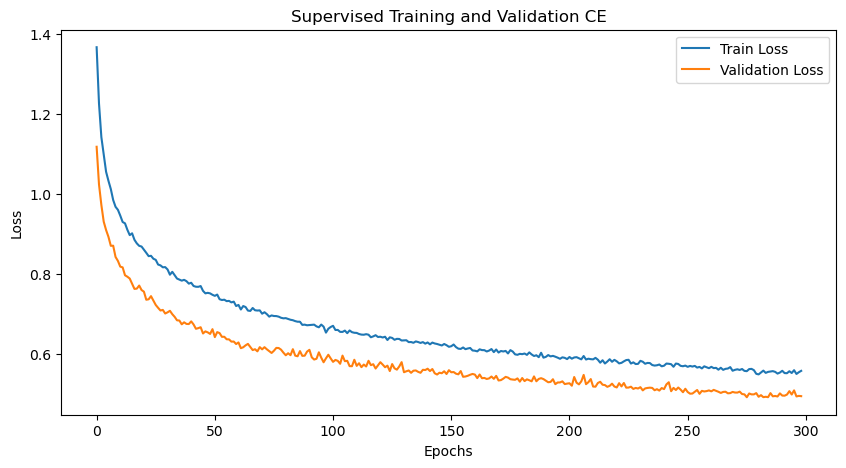

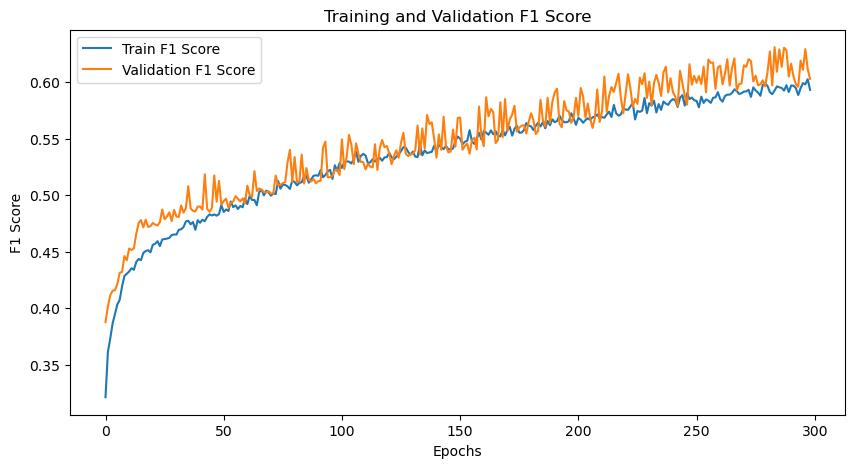

In [41]:
UPFall_X = np.array(UPFall_X)
UPFall_y = np.array(UPFall_y)

X_train_by_activity, X_val_by_activity, y_train_by_activity, y_val_by_activity = train_test_split(UPFall_X, UPFall_y, test_size=0.33, random_state=42)

train_data_by_activity = Data_Supervised(X_train_by_activity, y_train_by_activity)
val_data_by_activity = Data_Supervised(X_val_by_activity, y_val_by_activity)
train_loader_by_activity = DataLoader(train_data_by_activity, batch_size=256, shuffle=True)
val_loader_by_activity = DataLoader(val_data_by_activity, batch_size=256, shuffle=True)

vae_model.load_state_dict(torch.load('vae.pth'))
# freeze the encoder
# for param in vae_model.encoder.parameters():
#         param.requires_grad = False
        
classifier = Classifier(latent_dim=latent_dim)
train_losses, val_losses, train_f1_scores, val_f1_scores = train_classifier(vae_model.encoder, classifier, train_loader_by_activity, val_loader_by_activity, epochs=300, learning_rate=0.01)

# Plotting the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Supervised Training and Validation CE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training and validation F1 scores
plt.figure(figsize=(10, 5))
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()